In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
import seaborn as sb

### Preprocessing

In [50]:
#loading the data
df_train = pd.read_csv('../input/dapprojekt22/train.csv')
df_test = pd.read_csv('../input/dapprojekt22/test.csv')

df_train.head()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_HOME,NEXT_AWAY,NEXT_WINNER,NEXT_WEIGHT
0,17,17,0.472,0.500,12.7,13.8,0.89,0.81,18,6,...,19,14,0.452,0.424,0.197,0.198,MIA,CHI,0.0,1.489674
1,23,26,0.657,0.703,17.0,19.9,1.21,1.30,7,4,...,18,26,0.375,0.591,0.198,0.196,LAL,LAC,0.0,5.361710
2,27,23,0.659,0.548,19.8,15.6,1.69,1.21,6,4,...,18,27,0.462,0.435,0.200,0.200,CLE,BKN,0.0,2.357026
3,24,21,0.727,0.600,18.2,15.7,1.60,1.50,3,8,...,20,21,0.426,0.525,0.200,0.195,PHI,MIA,0.0,5.980445
4,30,24,0.714,0.558,21.5,18.1,1.58,1.33,1,0,...,32,26,0.485,0.520,0.200,0.200,TOR,BOS,0.0,1.283159


In [51]:
# dropping missing values
df_missing = df_train.isna().sum()[df_train.isna().sum() != 0]

df_train.drop(columns=df_missing.index.values, inplace=True)
df_test.drop(columns=df_missing.index.values, inplace=True)

In [52]:
# removing constant features and monotonous ones
df_nunique1 = df_train.nunique()[df_train.nunique() == 1]
df_nunique3000 = df_train.nunique()[df_train.nunique() >= 3000]

df_train.drop(columns=df_nunique1.index.values, inplace=True)
df_test.drop(columns=df_nunique1.index.values, inplace=True)

df_train.drop(columns=df_nunique3000.index.values, inplace=True)
df_test.drop(columns=df_nunique3000.index.values, inplace=True)

In [53]:
# change min_home and min_away from categorical to integer
df_train['MIN_HOME'] = np.int32(df_train['MIN_HOME'].str.split(':').str[0])
df_train['MIN_AWAY'] = np.int32(df_train['MIN_AWAY'].str.split(':').str[0])

df_test['MIN_HOME'] = np.int32(df_test['MIN_HOME'].str.split(':').str[0])
df_test['MIN_AWAY'] = np.int32(df_test['MIN_AWAY'].str.split(':').str[0])

In [54]:
# save and drop categoricals from train
df_categorical_train = df_train.select_dtypes(include=['object']).copy()
df_categorical_test = df_test.select_dtypes(include=['object']).copy()

df_train.drop(columns=df_categorical_train.columns.values.tolist(), inplace=True)
df_test.drop(columns=df_categorical_test.columns.values.tolist(), inplace=True)

In [55]:
# drop next weight
df_train.drop(columns=['NEXT_WEIGHT'], inplace=True)

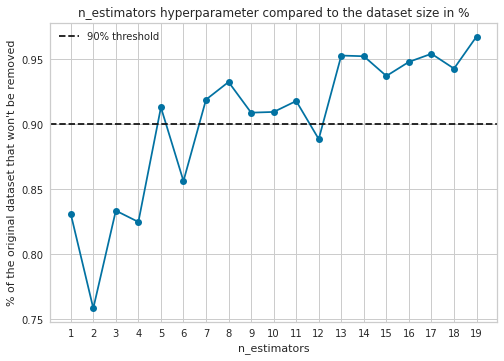

In [56]:
# detect outliers
d = {}
df_train_wo_nw = df_train.loc[:, df_train.columns != 'NEXT_WINNER']
for i in range(1, 20):
    lof = IsolationForest(n_estimators=i)
    X_out = lof.fit_predict(df_train_wo_nw)
    d[i] = np.sum(X_out == 1)/len(X_out)

plt.plot(list(d.keys()), list(d.values()), '-o')
plt.xticks(list(d.keys()))
plt.xlabel('n_estimators')
plt.ylabel('% of the original dataset that won\'t be removed')
plt.title('n_estimators hyperparameter compared to the dataset size in %')
plt.axhline(y=0.9, c='k', linestyle='dashed', label='90% threshold')
plt.legend()
plt.show()

In [57]:
# remove outliers
lof = IsolationForest(n_estimators=6)
X_out = lof.fit_predict(df_train_wo_nw)
rows_to_drop = np.where(X_out == -1)[0]

df_train.drop(df_train.index[list(rows_to_drop)], inplace=True)
df_categorical_train.drop(df_categorical_train.index[list(rows_to_drop)], inplace=True)

In [58]:
# remove id variables
df_train.drop(columns=['TEAM_ID_AWAY', 'TEAM_ID_HOME'], inplace=True)
df_test.drop(columns=['TEAM_ID_AWAY', 'TEAM_ID_HOME'], inplace=True)

In [59]:
df_train = pd.concat((df_categorical_train[['TEAM_ABBREVIATION_AWAY', 'TEAM_ABBREVIATION_HOME']], df_train), axis=1)
df_test = pd.concat((df_categorical_test[['TEAM_ABBREVIATION_AWAY', 'TEAM_ABBREVIATION_HOME']], df_test), axis=1)

df_train.head()

,TEAM_ABBREVIATION_AWAY,TEAM_ABBREVIATION_HOME,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,...,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_WINNER
0,ORL,IND,17,17,0.472,0.500,12.7,13.8,0.89,0.81,...,0.570,42,33,19,14,0.452,0.424,0.197,0.198,0.0
1,CHI,MIA,23,26,0.657,0.703,17.0,19.9,1.21,1.30,...,0.631,48,44,18,26,0.375,0.591,0.198,0.196,0.0
2,LAC,LAL,27,23,0.659,0.548,19.8,15.6,1.69,1.21,...,0.551,39,62,18,27,0.462,0.435,0.200,0.200,0.0
3,BKN,CLE,24,21,0.727,0.600,18.2,15.7,1.60,1.50,...,0.495,47,40,20,21,0.426,0.525,0.200,0.195,0.0
4,MIA,PHI,30,24,0.714,0.558,21.5,18.1,1.58,1.33,...,0.629,66,50,32,26,0.485,0.520,0.200,0.200,0.0


In [60]:
# df_train = pd.concat((df_train, df_categorical_train[['TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY']]), axis=1)
df_train.reset_index(drop=True, inplace=True)
df_train.head()

,TEAM_ABBREVIATION_AWAY,TEAM_ABBREVIATION_HOME,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,...,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME,NEXT_WINNER
0,ORL,IND,17,17,0.472,0.500,12.7,13.8,0.89,0.81,...,0.570,42,33,19,14,0.452,0.424,0.197,0.198,0.0
1,CHI,MIA,23,26,0.657,0.703,17.0,19.9,1.21,1.30,...,0.631,48,44,18,26,0.375,0.591,0.198,0.196,0.0
2,LAC,LAL,27,23,0.659,0.548,19.8,15.6,1.69,1.21,...,0.551,39,62,18,27,0.462,0.435,0.200,0.200,0.0
3,BKN,CLE,24,21,0.727,0.600,18.2,15.7,1.60,1.50,...,0.495,47,40,20,21,0.426,0.525,0.200,0.195,0.0
4,MIA,PHI,30,24,0.714,0.558,21.5,18.1,1.58,1.33,...,0.629,66,50,32,26,0.485,0.520,0.200,0.200,0.0


In [15]:
df_train.columns.tolist()

['TEAM_ABBREVIATION_AWAY',
 'TEAM_ABBREVIATION_HOME',
 'AST_AWAY',
 'AST_HOME',
 'AST_PCT_AWAY',
 'AST_PCT_HOME',
 'AST_RATIO_AWAY',
 'AST_RATIO_HOME',
 'AST_TOV_AWAY',
 'AST_TOV_HOME',
 'BLKA_AWAY',
 'BLKA_HOME',
 'BLK_AWAY',
 'BLK_HOME',
 'CFGA_AWAY',
 'CFGA_HOME',
 'CFGM_AWAY',
 'CFGM_HOME',
 'CFG_PCT_AWAY',
 'CFG_PCT_HOME',
 'DEF_RATING_AWAY',
 'DEF_RATING_HOME',
 'DFGA_AWAY',
 'DFGA_HOME',
 'DFGM_AWAY',
 'DFGM_HOME',
 'DFG_PCT_AWAY',
 'DFG_PCT_HOME',
 'DIST_AWAY',
 'DIST_HOME',
 'DRBC_AWAY',
 'DRBC_HOME',
 'DREB_AWAY',
 'DREB_HOME',
 'DREB_PCT_AWAY',
 'DREB_PCT_HOME',
 'EFG_PCT_AWAY',
 'EFG_PCT_HOME',
 'FG3A_AWAY',
 'FG3A_HOME',
 'FG3M_AWAY',
 'FG3M_HOME',
 'FG3_PCT_AWAY',
 'FG3_PCT_HOME',
 'FGA_AWAY',
 'FGA_HOME',
 'FGM_AWAY',
 'FGM_HOME',
 'FG_PCT_AWAY',
 'FG_PCT_HOME',
 'FTAST_AWAY',
 'FTAST_HOME',
 'FTA_AWAY',
 'FTA_HOME',
 'FTA_RATE_AWAY',
 'FTA_RATE_HOME',
 'FTM_AWAY',
 'FTM_HOME',
 'FT_PCT_AWAY',
 'FT_PCT_HOME',
 'MIN_AWAY',
 'MIN_HOME',
 'NET_RATING_AWAY',
 'NET_RATING_HOM

In [61]:
print(df_categorical_train.shape)
print(df_train.shape)

(2838, 8)
(2838, 167)


In [62]:
import warnings
warnings.filterwarnings('ignore')

def calculate_features_for_set(df, d, start=1):
    home, away = 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY'
    home_col = [i for i in filter(lambda x: x.endswith('HOME'), df.columns.tolist())]
    away_col = [i for i in filter(lambda x: x.endswith('AWAY'), df.columns.tolist())]
    
    print('Calculating features for dataset . . .')
    for i in range(start, df.shape[0]):
        if i % 400 == 399:
            print(f'Iteration {i+1}')
        
        rows_before = df.loc[0:i-1]
        row_curr = df.loc[i]
        
        curr_home, curr_away = row_curr[home], row_curr[away]
        
        mask1 = (rows_before[home] == curr_home) & (rows_before[away] == curr_away)
        mask2 = (rows_before[away] == curr_home) & (rows_before[home] == curr_away)
        
        rows_home = rows_before[mask1]
        rows_away = rows_before[mask2]
        
        if rows_home.empty and rows_away.empty:
            [d[k].append(0) for k in d.keys()]
        
        elif rows_home.empty:
            res = rows_away.mean()
            for i, k in enumerate(d.keys()):
                k2 = k.replace('AWAY', 'HOME') if 'AWAY' in k else k.replace('HOME', 'AWAY')
                d[k2].append(res[k])
                    
        elif rows_away.empty:
            res = rows_home.mean()
            [d[k].append(res[k]) for i, k in enumerate(d.keys())]
        
        else:
            res1 = rows_away.mean()
            res2 = rows_home.mean()
            for i, k in enumerate(d.keys()):
                k2 = k.replace('AWAY', 'HOME') if 'AWAY' in k else k.replace('HOME', 'AWAY')
                d[k].append((res1[k2] + res2[k])/2)
            
    return pd.DataFrame.from_dict(d)

def define_features(df_train, df_test):
    data_train = {}
    data_test = {}
    
    # shifting makes calculating the features easier
    y_train = df_train['NEXT_WINNER'][:-1]
    x_train = df_train[1:].reset_index(drop=True)
    x_train.drop(columns=['NEXT_WINNER'], inplace=True)
    train_shifted = pd.concat((x_train, y_train), axis=1)
    merged = pd.concat((train_shifted, df_test)).drop(columns=['id']).reset_index(drop=True)

    home, away = 'TEAM_ABBREVIATION_HOME', 'TEAM_ABBREVIATION_AWAY'
   
    cols = [i for i in train_shifted.columns.tolist() if i != home and i != away and i != 'NEXT_WINNER']
    for c in cols:
        data_train[c] = []
        data_test[c] = []
    
    df_train_features = calculate_features_for_set(train_shifted, data_train)
    df_test_features = calculate_features_for_set(merged, data_test, start=len(train_shifted))
    
    return df_train_features, df_test_features

In [63]:
import time
start = time.time()
df_train_features, df_test_features = define_features(df_train, df_test)
end = time.time()
print(f'Time for executing the function {end-start}s')

Calculating features for dataset . . .
Iteration 400
Iteration 800
Iteration 1200
Iteration 1600
Iteration 2000
Iteration 2400
Iteration 2800
Calculating features for dataset . . .
Iteration 3200
Iteration 3600
Iteration 4000
Time for executing the function 33.77637338638306s


In [65]:
df_train_features.tail()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,TS_PCT_AWAY,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME
2831,20.000000,23.500000,0.483750,0.622000,15.587500,17.912500,1.916250,1.77250,6.625000,5.750000,...,0.570750,0.54850,47.625000,38.625000,23.000000,16.625000,0.481750,0.428375,0.199750,0.199000
2832,21.625000,24.000000,0.576125,0.617750,16.512500,18.375000,1.851250,1.57375,7.125000,3.875000,...,0.503750,0.57550,44.000000,48.125000,18.750000,23.375000,0.428000,0.484750,0.199500,0.200000
2833,21.000000,18.333333,0.615000,0.520542,16.962500,14.679167,1.570000,1.47375,4.791667,6.041667,...,0.540917,0.49450,42.708333,40.500000,18.208333,18.125000,0.427083,0.448958,0.198000,0.198250
2834,22.708333,23.166667,0.573333,0.596542,17.016667,17.008333,1.519583,1.51875,3.166667,5.458333,...,0.580667,0.54400,50.125000,48.583333,23.333333,21.000000,0.468208,0.426875,0.198583,0.198167
2835,20.083333,24.450000,0.532017,0.602667,15.113333,18.035000,1.664833,2.10100,6.183333,4.350000,...,0.523283,0.56695,41.833333,49.966667,17.816667,23.183333,0.422950,0.465450,0.199000,0.198900


In [66]:
df_test_features.tail()

,AST_AWAY,AST_HOME,AST_PCT_AWAY,AST_PCT_HOME,AST_RATIO_AWAY,AST_RATIO_HOME,AST_TOV_AWAY,AST_TOV_HOME,BLKA_AWAY,BLKA_HOME,...,TS_PCT_AWAY,TS_PCT_HOME,UFGA_AWAY,UFGA_HOME,UFGM_AWAY,UFGM_HOME,UFG_PCT_AWAY,UFG_PCT_HOME,USG_PCT_AWAY,USG_PCT_HOME
1225,24.200000,21.500000,0.658600,0.628900,18.780000,16.820000,1.476000,1.321000,4.200000,4.400000,...,0.570600,0.519000,45.700000,42.700000,22.400000,17.500000,0.491200,0.412000,0.198800,0.198800
1226,22.583333,18.666667,0.589583,0.526917,18.150000,15.183333,1.919167,1.475833,5.916667,5.000000,...,0.562500,0.506250,41.166667,37.250000,18.500000,15.000000,0.450083,0.406417,0.199667,0.198833
1227,22.600000,24.383333,0.619433,0.633067,16.983333,18.375000,1.804000,2.132167,6.166667,4.616667,...,0.531133,0.579050,44.716667,48.033333,20.700000,21.916667,0.463883,0.455983,0.198717,0.199400
1228,21.160714,27.928571,0.549750,0.664554,15.537500,19.742857,1.284464,1.846607,4.982143,4.392857,...,0.513875,0.579714,44.267857,42.535714,19.535714,19.053571,0.440429,0.447875,0.199429,0.198750
1229,20.783333,22.383333,0.528817,0.578850,16.318333,16.740000,2.102000,1.869167,4.550000,6.516667,...,0.537700,0.536617,44.166667,48.566667,19.950000,21.266667,0.451750,0.434550,0.199267,0.199467


### Clustering

Clustering algorithms transform the data into sets that consist of similar examples. On this particular dataset this could be used to create new features for classification by grouping games by certain features, grouping similar features to lower the dimensionality or for exploratory analysis. 

Some well known algorithms for this are:
1. KMeans
2. DBSCAN
3. Gaussian mixtures

The hyperparameter we need to determine for using KMeans is the number of groups $k$. We can determine this by calculating the inertia for each of the models and determining where the "elbow" is on the plot. This point can be intuitively explained because it doesn't make much sense to add more components if the inertia doesn't get significantly smaller.

Inertia is defined as:
$$\sum_{i=0}^{n} \min_{\mu_j \in C}{(||x_i - \mu_j||^2)}$$
In this formula $x_i$ represents the data point $i$ and $\mu_j$ represents the centroid point for group $j$.

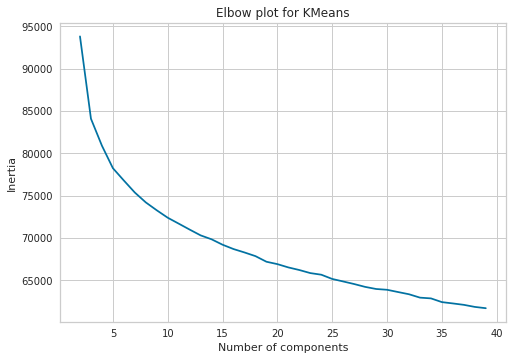

In [67]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def do_elbow_plot(data, range_ = range(2, 40)):
    inertia = []
    for i in range_:
        pipeline = Pipeline([
            ('scaler', StandardScaler()), 
            ('kmeans', KMeans(i))
        ])
        pipeline.fit_transform(data)
        inertia.append(pipeline['kmeans'].inertia_)
    plt.plot(range_, inertia)
    plt.xlabel('Number of components')
    plt.ylabel('Inertia')
    plt.title('Elbow plot for KMeans')
    
do_elbow_plot(df_train_features)


For this particular graph dataset I would set the number of components $k$ to 5.

In [68]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(5))
])
kmeans_labels = pipeline.fit_predict(df_train_features)
kmeans_labels

array([1, 1, 1, ..., 0, 2, 4], dtype=int32)

A better visualization tool for evaluating these clusters is a silhouette score plot. The dotted red line represents the average silhouette score. Each of the clusters should have at least one silhouette coefficient value higher than the average score. 

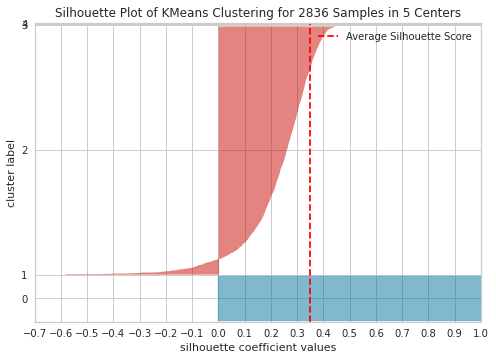

In [69]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(pipeline['kmeans'], colors='yellowbrick')

visualizer.fit(df_train_features)
visualizer.show()
plt.show()

Next up is DBSCAN algorithm. This is a different approach compared to KMeans as it uses the high density found in natural clusters and also finds outliers as a separate cluster. KMeans tends to focus on spherical groups while DBSCAN can easily find unnatural looking groups. 

This algorithm uses 2 most important hyperparameters:
1. eps - the maximum distance between two samples for one to be in the others' neighborhood
2. min_samples - the number of samples in a neighborhood for a point to be considered a core point

The end result consists of clusters which consist of so called core points and reachable points. Points that are neither core points nor directly-reachable are considered as outliers and form a separate cluster.

For determining hyperparameter values we can use Davies Bouldin index where the validation of how well the clustering has been done is made using quantities and features inherent to the dataset. Lower values indicate better clusters.

In [70]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

dbs_dict = {}
min_s_range = range(2, 20, 1)
eps_range = range(1, 50)

for min_s in min_s_range:
    print(f'Iteration {min_s}')
    for i in eps_range:
        pipeline = Pipeline([
            ('scaler', StandardScaler()), 
            ('dbscan', DBSCAN(eps=i*0.05, min_samples=min_s))
        ])
        y = pipeline.fit_predict(df_train_features)
        dbs = davies_bouldin_score(df_train_features, y)
        dbs_dict[(min_s, i)] = dbs

Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


In [71]:
print(f'Minimum value: {min(dbs_dict.values())} for i, j: {min(dbs_dict, key=dbs_dict.get)}')

Minimum value: 0.07538039060814435 for i, j: (2, 1)


In [72]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('dbscan', DBSCAN(eps=0.05, min_samples=2))
])
dbscan_labels = pipeline.fit_predict(df_train_features)
dbscan_labels

array([ 0,  0,  0, ..., -1, -1, -1])

Finally, the third algorithm we'll be looking at is Gaussian mixture models. This is a probabilistic generative model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. It estimates probabilities but we can easily obtain the clusters for these probabilities. 

Important hyperparameters:
1. number of components - the number of assumed Gaussian distributions with unknown parameters
1. covariance_type - the type of covariance matrix for each of these distributions

In order to find the we can use BIC or AIC. Both of these criterions take into account the log likelihood of the model and the complexity. Models with lower BIC are preferred.

This algorithm also works best with spherical groups, but it's a lot more powerful than the KMeans algorithm because it's a generalized version of KMeans. KMeans assumes that the covariances are isotropic while gaussian mixture models do not.

Calculating spherical . . .
Calculating tied . . .
Calculating diag . . .
Calculating full . . .


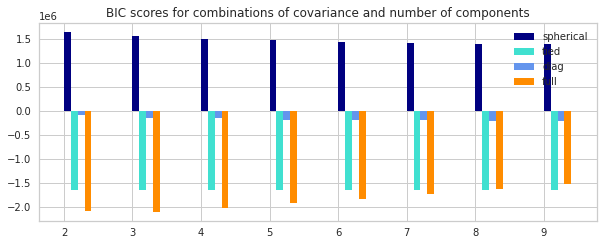

In [73]:
from sklearn.mixture import GaussianMixture
import itertools as it

bic = []
n_components_range = range(2, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    print(f'Calculating {cv_type} . . .')
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(df_train_features)
        bic.append(gmm.bic(df_train_features))

bic = np.array(bic)
color_iter = it.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
bars = []

plt.figure(figsize=(10, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + i*0.1 + 0.05
    bars.append(
        plt.bar(
            xpos,
            bic[i*len(n_components_range):(i + 1)*len(n_components_range)],
            width=0.1,
            color=color,
            label=cv_type
        )
    )
plt.title('BIC scores for combinations of covariance and number of components')
plt.legend()
plt.show()

The full covariance matrix and 3 components seems to be the winner here.

In [74]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm_labels = gmm.fit_predict(df_train_features)
gmm_labels

array([1, 1, 1, ..., 2, 2, 2])

### Cluster visualization using dimensionality reduction

There is a problem that the dataset consists of a 164 features but we can visualize data only only up to 3 dimensions. Here we can use dimensionality reduction techniques such as:

1. PCA
2. t-SNE

Both of these algorithms use a lot of hyperparameters, but for visualization the most important one is the number of components. We can visualize data in 3-dimensional or 2-dimensional space so it will be set to 2 or 3.

In [75]:
from sklearn.decomposition import PCA

pca = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=2))
])

df_train_features_pca = pd.DataFrame(pca.fit_transform(df_train_features))

In [76]:
df_train_features_pca.head()

,0,1
0,26.917847,0.007382
1,26.917847,0.007382
2,26.917847,0.007382
3,26.917847,0.007382
4,26.917847,0.007382


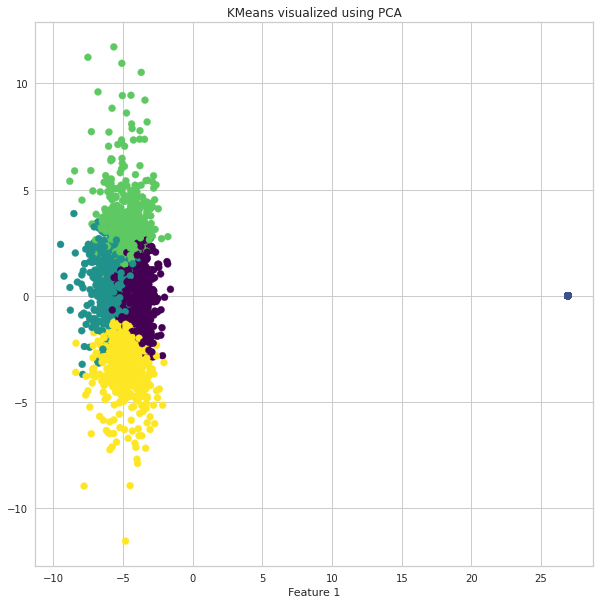

In [77]:
def do_dim_red_plot(labels, alg_name, df, dim_red_name, cmap='viridis'):
    plt.figure(figsize=(10, 10))
    plt.scatter(df[0], df[1], c=labels, cmap=cmap)
    plt.xlabel('Feature 0')
    plt.xlabel('Feature 1')
    plt.title(f'{alg_name} visualized using {dim_red_name}')
    plt.show()
    
do_dim_red_plot(kmeans_labels, 'KMeans', df_train_features_pca, 'PCA')

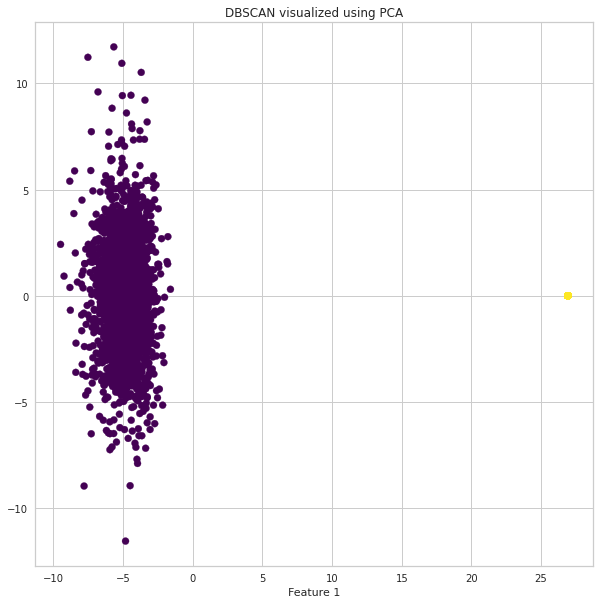

In [78]:
do_dim_red_plot(dbscan_labels, 'DBSCAN', df_train_features_pca, 'PCA')

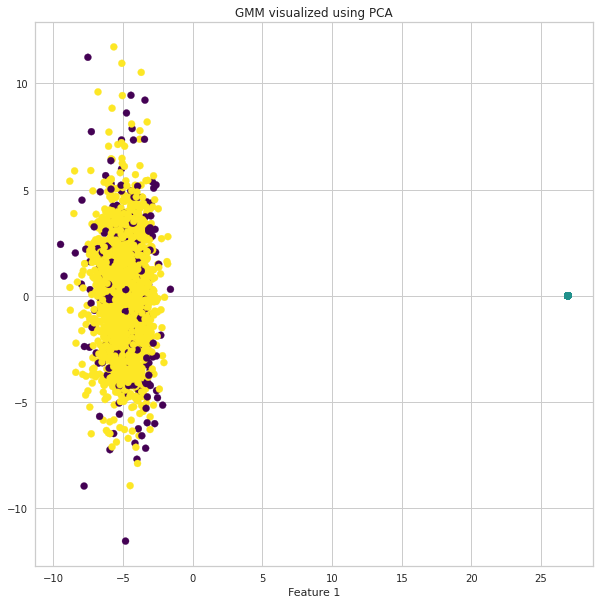

In [79]:
do_dim_red_plot(gmm_labels, 'GMM', df_train_features_pca, 'PCA')

We can see that the DBSCAN PCA plot makes most sense, but in reality the situation is probably different. The problem with our data is that the first few examples aren't really representative and consist of all zeros. These methods might give completely different results if removed the first 500 examples. 

In [93]:
from sklearn.manifold import TSNE

tsne = Pipeline([
    ('scaler', StandardScaler()), 
    ('tsne', TSNE(n_components=2))
])

df_train_features_tsne = pd.DataFrame(tsne.fit_transform(df_train_features))

In [94]:
df_train_features_tsne.head()

,0,1
0,-7.145789,59.796066
1,-7.185541,65.295219
2,-7.185541,65.295219
3,-7.185541,65.295219
4,-7.185541,65.295219


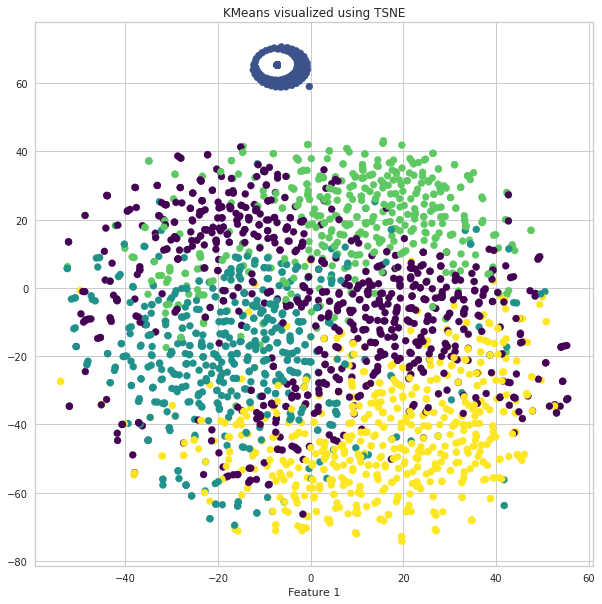

In [95]:
do_dim_red_plot(kmeans_labels, 'KMeans', df_train_features_tsne, 'TSNE')

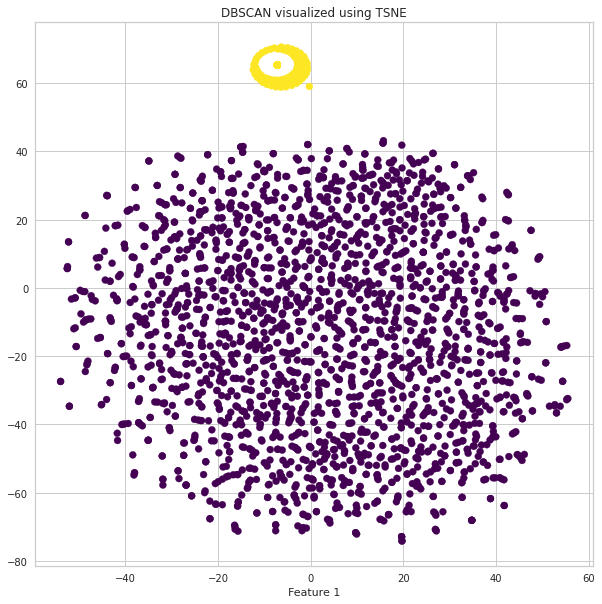

In [96]:
do_dim_red_plot(dbscan_labels, 'DBSCAN', df_train_features_tsne, 'TSNE')

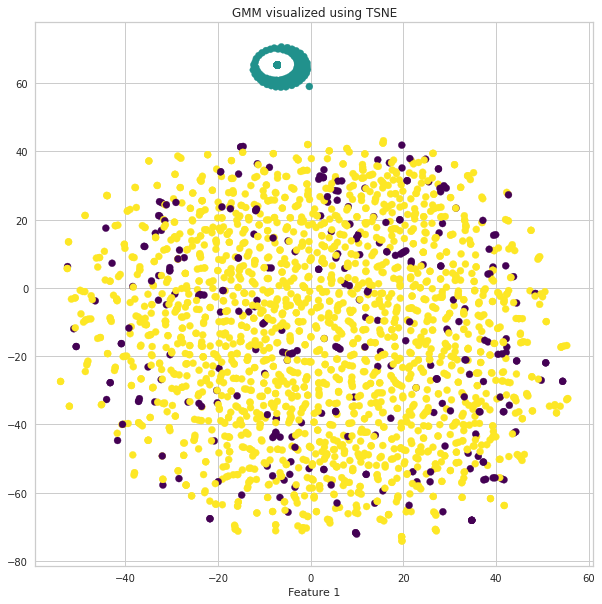

In [97]:
do_dim_red_plot(gmm_labels, 'GMM', df_train_features_tsne, 'TSNE')

We can see some very interesting results using the TSNE method. The DBSCAN clustering here makes the most sense.